# Example of Polyhedral Unmixing on the Samson and Battery datasets (short version).

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.unmixing import norm, normalized, import_mlab_image, preprocess_image
from src.unmixing import unmix

## 1. SAMSON

Load the Samson dataset

In [2]:
image_path = "./datasets/samson/samson.mat"
label_path = "./datasets/samson/ground_truth.mat"

image = import_mlab_image(image_path, image_key='V')
image_side = int(np.round(np.sqrt(image.shape[-1])))
image = image.T.reshape(image_side, image_side, image.shape[0]).swapaxes(0,1)

label = import_mlab_image(label_path, image_key='A')
label_side = int(np.round(np.sqrt(label.shape[-1])))
label = label.T.reshape(label_side, label_side, label.shape[0]).swapaxes(0,1)

label_spectra = import_mlab_image(label_path, image_key='M')
label_spectra = label_spectra.T

Show the Samason dataset

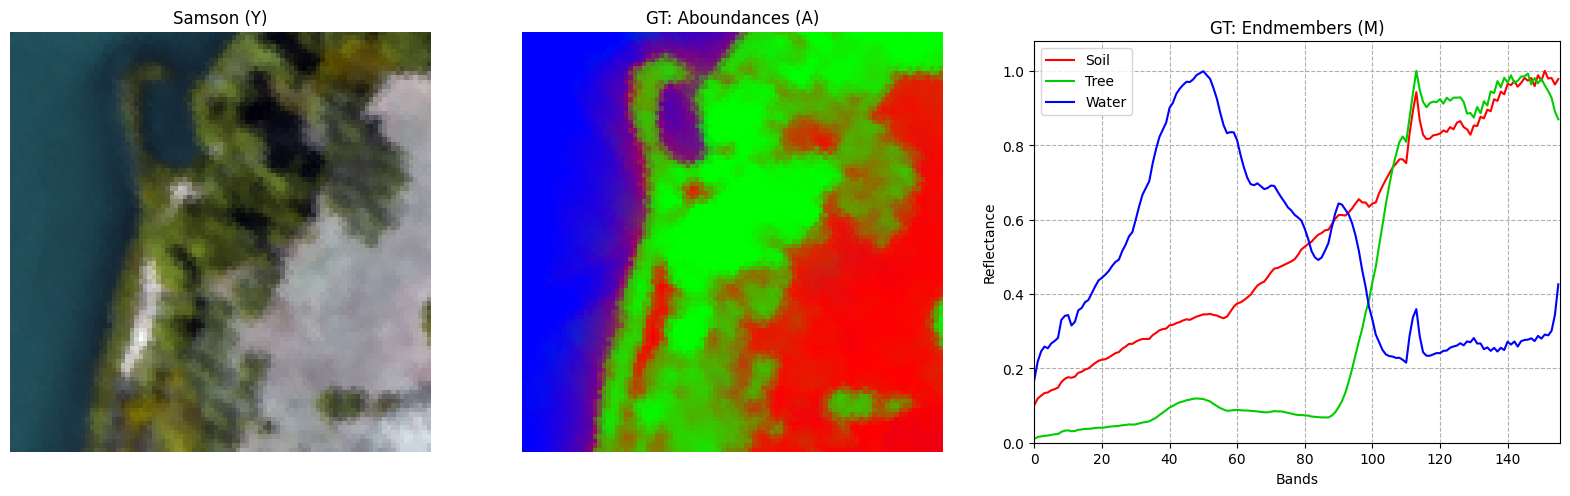

Image size: (95, 95) 
Bands: 156


In [3]:
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [80, 80, 100]}, figsize=(20,6))

ax[0].imshow(normalized(np.transpose((
    normalized(  0.6 * normalized(image[:,:,98]) + 0.2 * normalized(image[:,:,90]) + 0.7 * normalized(image[:,:,50])), 
    normalized(  0.1 * normalized(image[:,:,98]) - 0.3 * normalized(image[:,:,90]) + 0.8 * normalized(image[:,:,50])), 
    normalized(- 0.5 * normalized(image[:,:,98]) + 0.4 * normalized(image[:,:,90]) + 0.9 * normalized(image[:,:,50]))
), axes=(1,2,0))))
ax[0].set_axis_off()
ax[0].set_title("Samson (Y)")

ax[1].imshow(normalized(label))
ax[1].set_axis_off()
ax[1].set_title("GT: Aboundances (A)")

X = np.arange(label_spectra.shape[1])
for i in range(label_spectra.shape[0]):
    col = (int(i==0), 0.8*int(i==1), int(i==2))
    lab = "Soil" * int(i==0) + "Tree" * int(i==1) + "Water" * int(i==2)
    ax[2].plot(X, label_spectra[i], c=col, label=lab)
ax[2].legend()
ax[2].set_xlim(-0.1,155.5)
ax[2].set_ylim(0,1.08)
ax[2].set_ylabel("Reflectance")
ax[2].set_xlabel("Bands")
ax[2].grid(linestyle="--")
ax[2].set_aspect(110)
ax[2].set_title("GT: Endmembers (M)")

plt.show()

print("Image size:",image.shape[:-1],"\nBands:",image.shape[-1])

Set the classes to extract (either number of classes, class spectra or class coordinates on input image)

In [4]:
n_classes = 3
class_coordinates = [(-1, -1), (45, 41), (0, 0)]

classes = class_coordinates #n_classes

#### We use the "probability' method (2nd method presented in example_detailed.ipynb)

In [5]:
densities, segmented, endmembers = unmix(
    image = image, 
    classes = classes, 
    preprocess_homogenize = True, 
    preprocess_PCA_ndim = 12, 
    polyhedral_sample_prop = 0.2, 
    polyhedral_n_init = 10, 
    polyhedral_method = 'GMM_SVM', 
    density_uniformize = True, 
    density_method = 'probability', 
    verbose = True
)

Spectral image - size: (95, 95); bands: 156
/!\ Considering parameter 'classes' as list of class coordinates.
Homogenizing luminance of Y (power = 1.0)... Done!
Reducing dimensionality with PCA (ndim = 12)... Done!
Extracting random sample (prop = 0.2)... Done!
Computing space polyhedral partitioning (method = 'GMM_SVM', n_classes = 3, n_init = 10):
* Fitting GMM model on data... Done!
* Predicting data on GMM model... Done!
* Computing SVM parameters... Done!
* Computing minimum H-descriptions... Done!
Deducing segmentation maps from polyhedral classes... Done!
Computing signed distances to polyhedral classes:
=> Positive distances:
* Processing class: 1 / 3... Done!
* Processing class: 2 / 3... 
Estimated computation time: 2.72 seconds
Done!
* Processing class: 3 / 3... Done!
=> Negative distances... Done!
Deducing endmembers M with the minimum signed distance per class... Done!
Uniformizing distances using D = D_{min}^{-1} Y ... Done!
Deducing true abundances... Done!


Show segmentation results

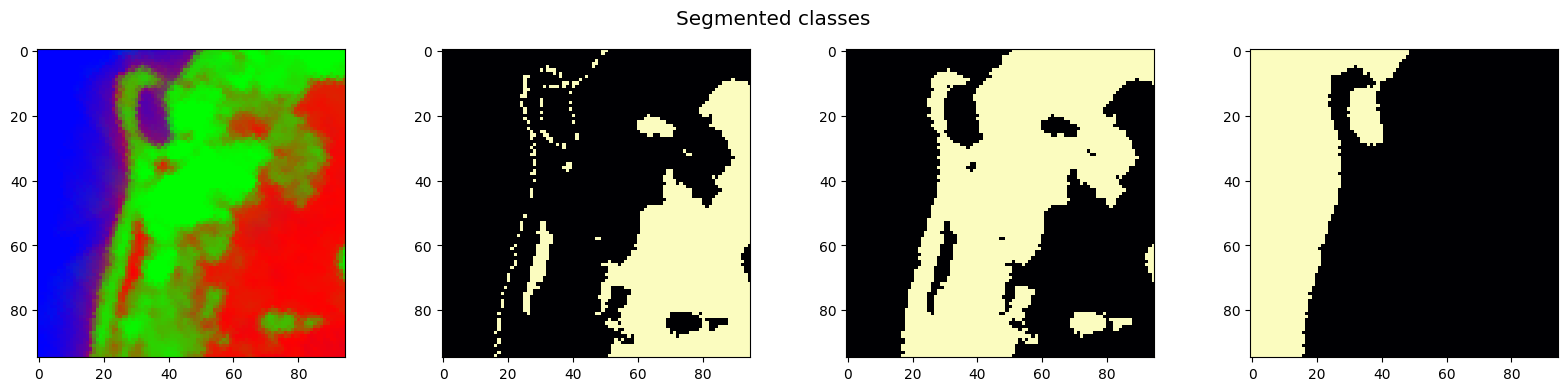

In [6]:
fig, ax = plt.subplots(1,n_classes+1,figsize=(5*(n_classes+1),4))
ax[0].imshow(label)
for i in range(n_classes):
    ax[i+1].imshow(segmented==i+1, cmap='magma')
fig.suptitle("Segmented classes", fontsize="x-large")
plt.show()

Show computed probability maps

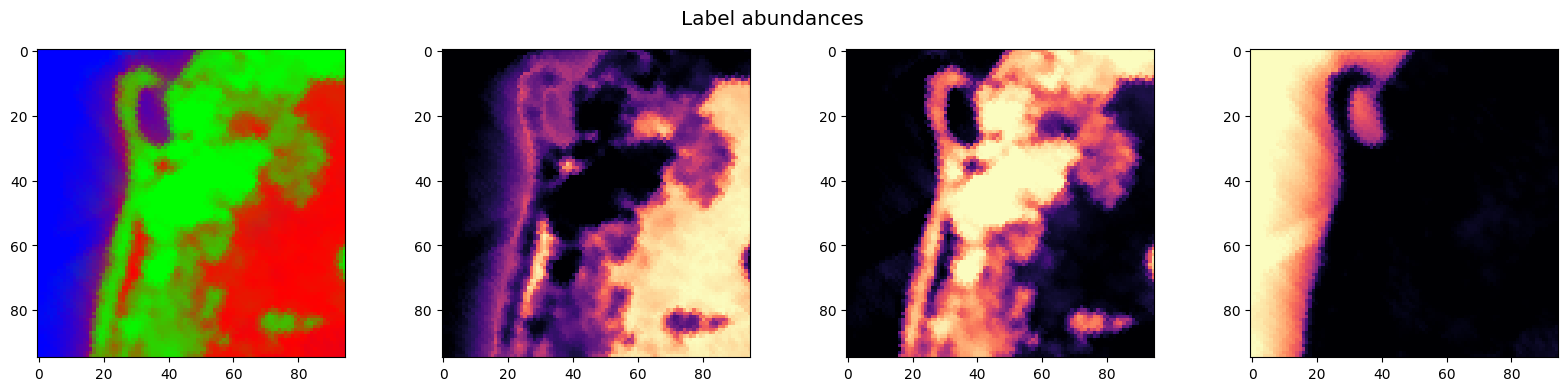

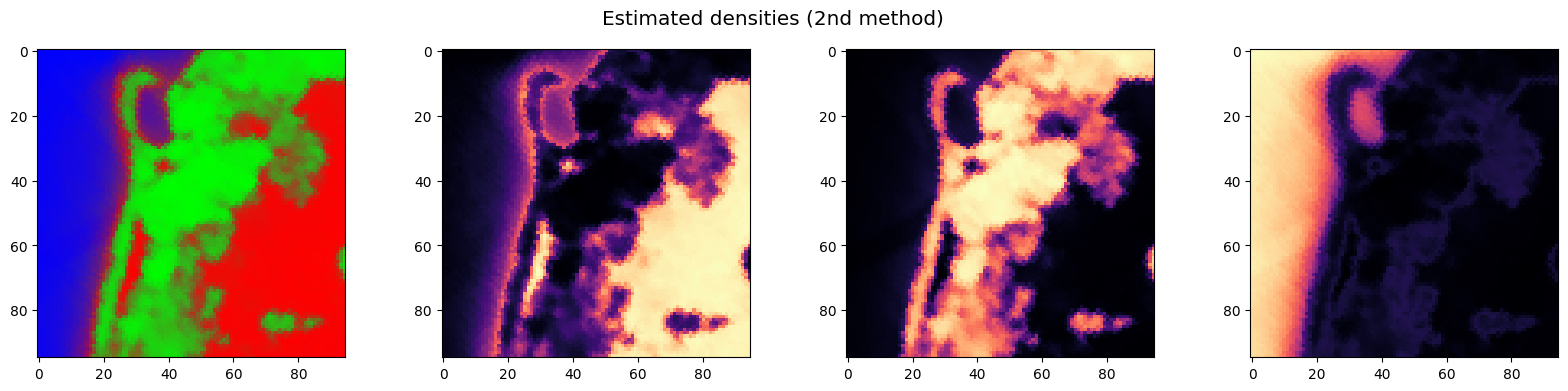

RMSE(A): 0.09705


In [7]:
fig, ax = plt.subplots(1,label.shape[-1]+1,figsize=(5*(label.shape[-1]+1),4))
ax[0].imshow(label[:,:,:3])
for i in range(label.shape[-1]):
    ax[i+1].imshow(label[:,:,i], cmap='magma')
fig.suptitle("Label abundances", fontsize="x-large")
plt.show()

fig, ax = plt.subplots(1,densities.shape[-1]+1,figsize=(5*(densities.shape[-1]+1),4))
ax[0].imshow(densities[:,:,:3])
for i in range(densities.shape[-1]):
    ax[i+1].imshow(densities[:,:,i], cmap='magma')
fig.suptitle("Estimated densities (2nd method)", fontsize="x-large")
plt.show()

print("RMSE(A):", np.round(np.sqrt(np.mean(np.square(norm(label-densities)))), decimals=5))

Show computed endmembers

In [8]:
GT_endmembers = preprocess_image(
    image = label_spectra, 
    homogenize_luminance = True
)

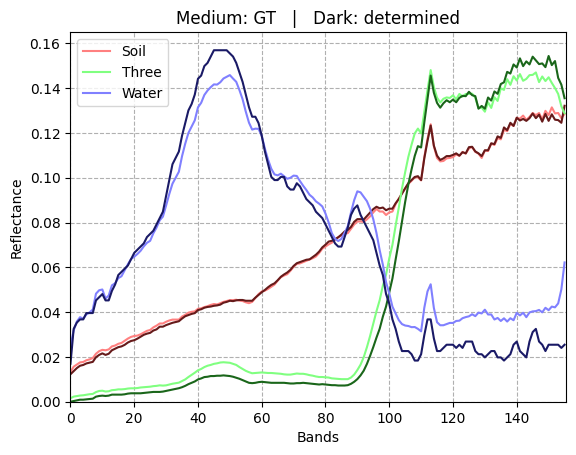

SUM OF SQUARED ERRORS (RGB): 0.0002 0.00508 0.01698


In [9]:
X = np.arange(GT_endmembers.shape[-1])
plt.plot(X, GT_endmembers[0], c=(1.0, 0.5, 0.5), label='Soil')
plt.plot(X,    endmembers[0], c=(0.4, 0.1, 0.1))
plt.plot(X, GT_endmembers[1], c=(0.5, 1.0, 0.5), label='Three')
plt.plot(X,    endmembers[1], c=(0.1, 0.4, 0.1))
plt.plot(X, GT_endmembers[2], c=(0.5, 0.5, 1.0), label='Water')
plt.plot(X,    endmembers[2], c=(0.1, 0.1, 0.4))
plt.legend()
plt.xlim(-0.1,155.5)
plt.ylim(0,0.165)
plt.ylabel("Reflectance")
plt.xlabel("Bands")
plt.grid(linestyle="--")
plt.title("Medium: GT   |   Dark: determined")
plt.show()

print("SUM OF SQUARED ERRORS (RGB):", *np.round(np.sum(np.square(endmembers - GT_endmembers), axis=-1), decimals=5))

## 2. BATTERY

Load the Battery grayscale image

In [10]:
slice_path = "./datasets/battery/slice.npy"
mask_path = "./datasets/battery/mask.npy"

img_slice = np.load(slice_path)
img_mask = np.load(mask_path)

Show the battery image and its mask

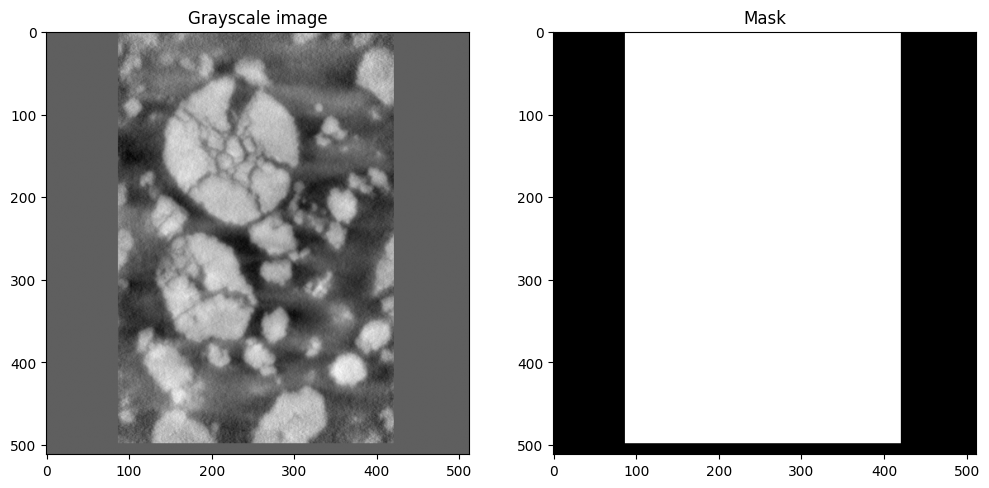

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(img_slice, cmap='gray')
ax[0].set_title("Grayscale image")
ax[1].imshow(img_mask, cmap='gray')
ax[1].set_title("Mask")
plt.show()

Set the classes to extract (either number of classes, class spectra or class coordinates on input image)

In [12]:
n_classes = 3
class_spectra = [img_slice[260, 240], img_slice[200, 210], img_slice[290, 380]]
class_coordinates = [(260, 240), (200, 210), (290, 380)]

classes = class_coordinates #class_spectra #n_classes

#### We use the "probability' method (2nd method presented in example_detailed.ipynb)

In [13]:
densities, segmented, endmembers = unmix(
    image = img_slice[:,:,None], 
    classes = classes, 
    mask = img_mask, 
    preprocess_homogenize = False, 
    preprocess_PCA_ndim = None, 
    polyhedral_sample_prop = 0.5, 
    polyhedral_n_init = 1, 
    polyhedral_method = 'KMeans_Voronoi', 
    density_uniformize = False, 
    density_method = 'probability', 
    verbose = True
)

Spectral image - size: (512, 512); bands: 1
/!\ Considering parameter 'classes' as list of class coordinates.
Extracting random sample (prop = 0.5)... Done!
Computing space polyhedral partitioning (method = 'KMeans_Voronoi', n_classes = 3, n_init = 1):
* Computing k-means centroids... Done!
* Computing Voronoi's class polyhedra from computed centroids... Done!
* Computing minimum H-descriptions... Done!
Deducing segmentation maps from polyhedral classes... Done!
Computing signed distances to polyhedral classes:
=> Positive distances:
* Processing class: 1 / 3... 
Estimated computation time: 28.53 seconds
Done!
* Processing class: 2 / 3... Done!
* Processing class: 3 / 3... Done!
=> Negative distances... Done!
Deducing endmembers M with the minimum signed distance per class... Done!
Deducing true abundances... Done!


Show segmentation results

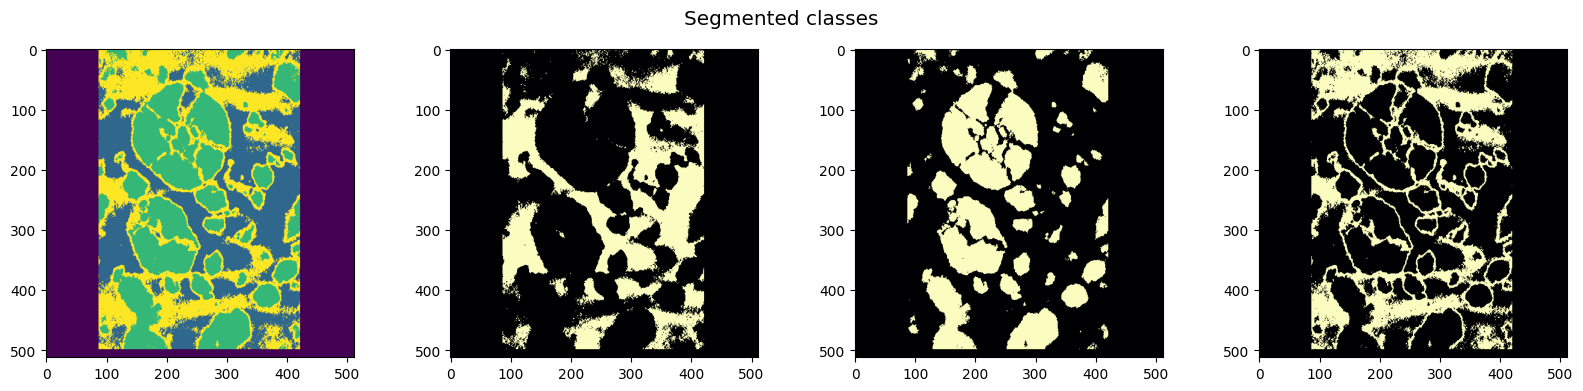

In [14]:
fig, ax = plt.subplots(1,n_classes+1,figsize=(5*(n_classes+1),4))
ax[0].imshow(segmented, vmax=n_classes)
for i in range(n_classes):
    ax[i+1].imshow(segmented==i+1, cmap='magma')
fig.suptitle("Segmented classes", fontsize="x-large")
plt.show()

Show density map results

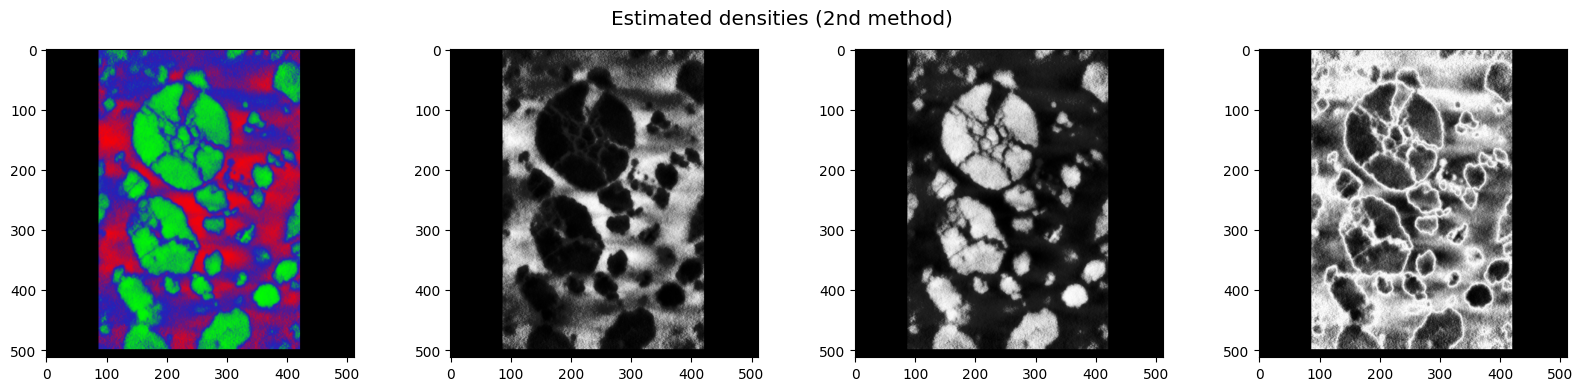

In [15]:
fig, ax = plt.subplots(1,densities.shape[-1]+1,figsize=(5*(densities.shape[-1]+1),4))
ax[0].imshow(densities[:,:,:3])
for i in range(densities.shape[-1]):
    ax[i+1].imshow(densities[:,:,i], cmap='gray')
fig.suptitle("Estimated densities (2nd method)", fontsize="x-large")
plt.show()

Show endmember results

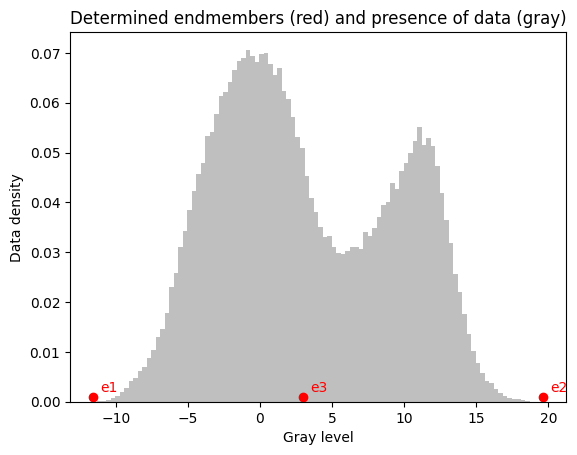

In [16]:
bins = 100
pos_e = 0.001

plt.hist(img_slice[img_mask], bins=bins, density=True, color=(0.75,0.75,0.75))
plt.scatter(x=endmembers[:,0], y=[pos_e]*endmembers.shape[0], color='red')
for i in range(endmembers.shape[0]):
    plt.text(x=endmembers[i,0]+0.5, y=2*pos_e, s=f'e{i+1}', color='red')
plt.ylabel('Data density')
plt.xlabel('Gray level')
plt.title("Determined endmembers (red) and presence of data (gray)")
plt.show()